In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import GridSearchCV
from gplearn.genetic import SymbolicRegressor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [11]:
data = pd.read_csv('POP.csv')
data.head()

,realtime_start,value,date,realtime_end
0,2019-12-06,156309.0,1952-01-01,2019-12-06
1,2019-12-06,156527.0,1952-02-01,2019-12-06
2,2019-12-06,156731.0,1952-03-01,2019-12-06
3,2019-12-06,156943.0,1952-04-01,2019-12-06
4,2019-12-06,157140.0,1952-05-01,2019-12-06


In [12]:
data = data.drop(['realtime_start','realtime_end'],axis=1)

In [13]:
"""Преобразование столбца даты в объект datetime и установка его в качестве индекса"""
data['date'] = pd.to_datetime(data['date'])
data.set_index('date',inplace=True)
data.head()

,value
date,
1952-01-01,156309.0
1952-02-01,156527.0
1952-03-01,156731.0
1952-04-01,156943.0
1952-05-01,157140.0


In [14]:
data.describe()

,value
count,816.000000
mean,243847.767826
std,50519.140567
min,156309.000000
25%,201725.250000
50%,239557.500000
75%,289364.250000
max,330309.946000


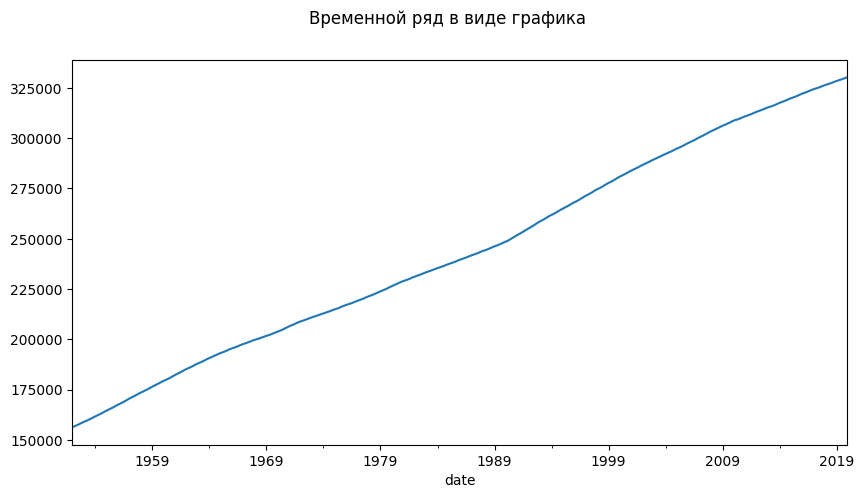

In [15]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Временной ряд в виде графика')
data.plot(ax=ax, legend=False)
pyplot.show()

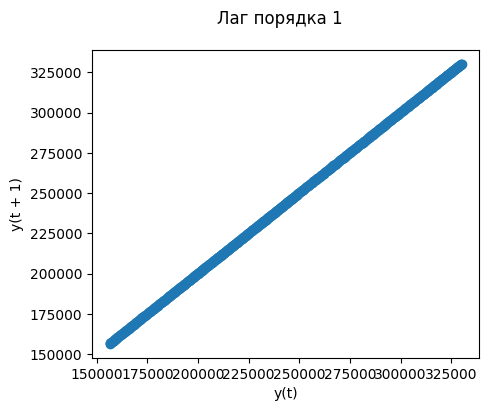

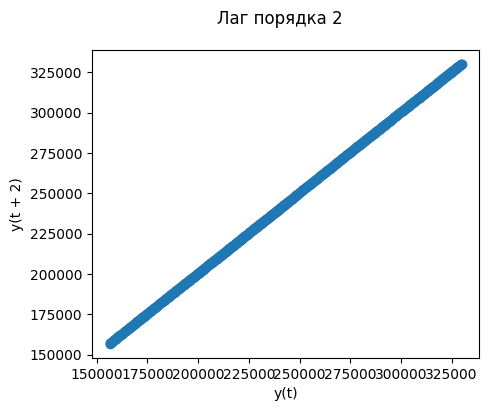

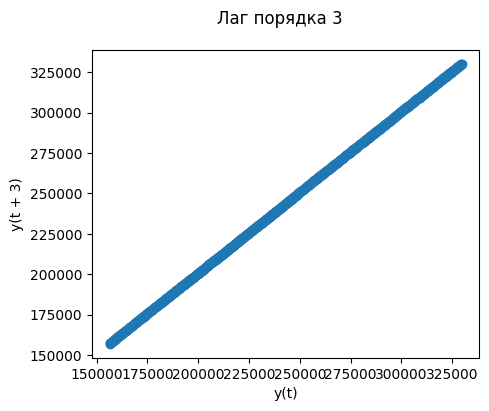

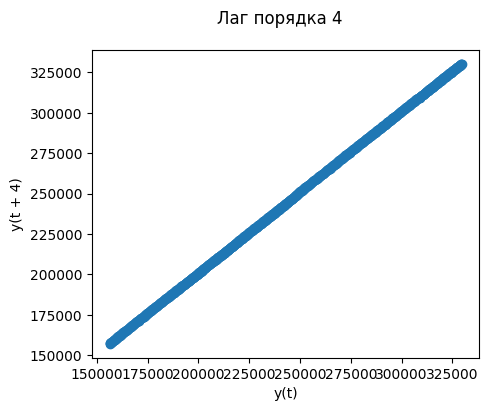

In [16]:
for i in range(1, 5):
    fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(5,4))
    fig.suptitle(f'Лаг порядка {i}')
    pd.plotting.lag_plot(data, lag=i, ax=ax)
    pyplot.show()

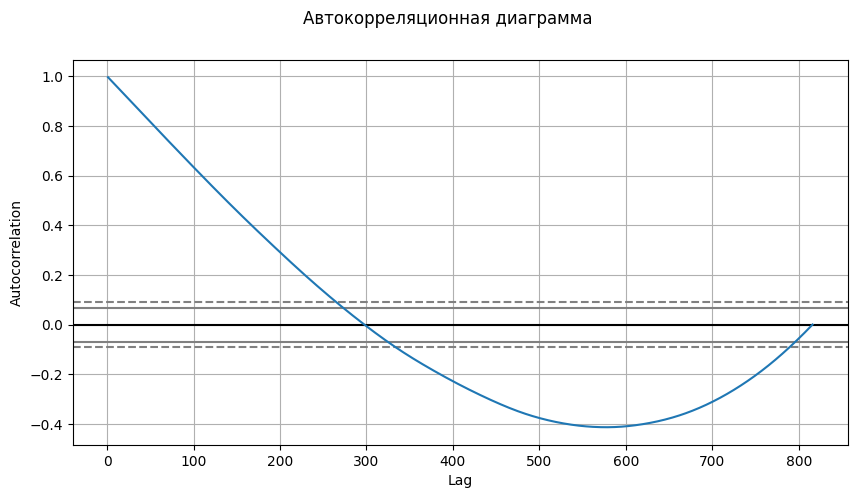

In [17]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Автокорреляционная диаграмма')
pd.plotting.autocorrelation_plot(data, ax=ax)
pyplot.show()

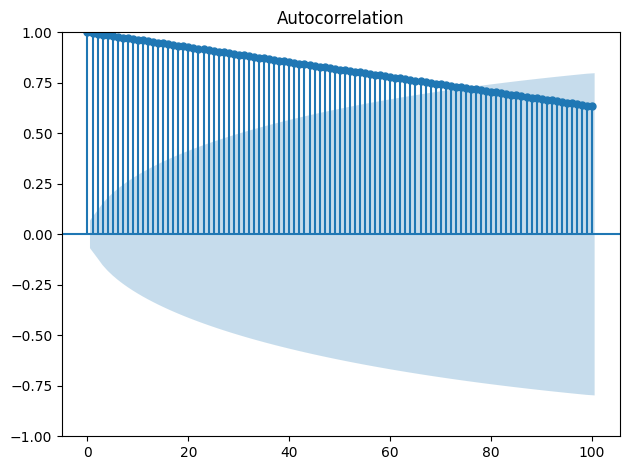

In [18]:
plot_acf(data, lags=100)
plt.tight_layout()

C:\Users\noski\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


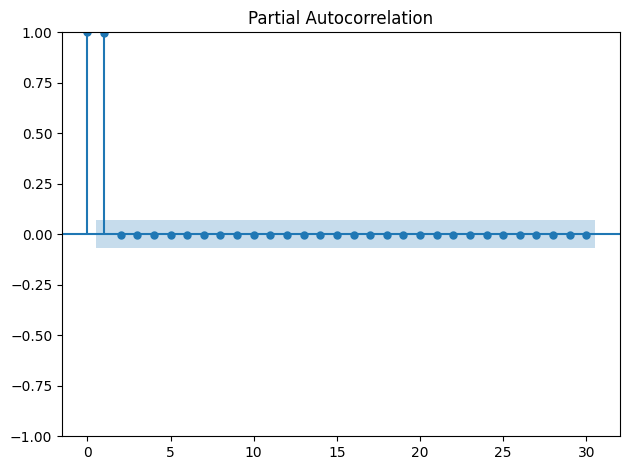

In [19]:
plot_pacf(data, lags=30)
plt.tight_layout()

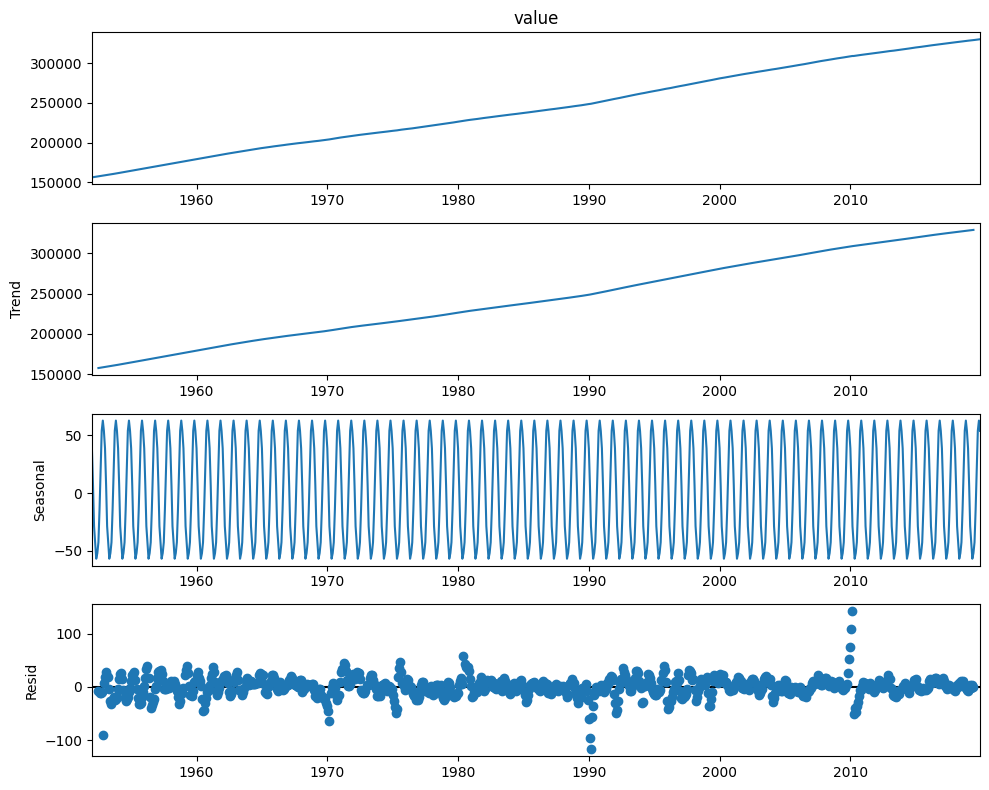

In [20]:
decomposed = seasonal_decompose(data['value'], model = 'add')
fig = decomposed.plot()
fig.set_size_inches((10, 8))
fig.tight_layout()
plt.show()

In [21]:
data_2 = data.copy()

In [22]:

# Целочисленная метка шкалы времени 
xnum = list(range(data_2.shape[0]))
# Разделение выборки на обучающую и тестовую
Y = data_2['value'].values
train_size = int(len(Y) * 0.7)
xnum_train, xnum_test = xnum[0:train_size], xnum[train_size:]
train, test = Y[0:train_size], Y[train_size:]
history_arima = [x for x in train]

In [23]:

# Параметры модели (p,d,q) 
arima_order = (2,1,0)
# Формирование предсказаний
predictions_arima = list()
for t in range(len(test)):
    model_arima = ARIMA(history_arima, order=arima_order)
    model_arima_fit = model_arima.fit()
    yhat_arima = model_arima_fit.forecast()[0]
    predictions_arima.append(yhat_arima)
    history_arima.append(test[t])
# Вычисление метрики RMSE
error_arima = mean_squared_error(test, predictions_arima, squared=False)

In [24]:
np.mean(Y), error_arima

(243847.7678259804, 24.173499561405922)

In [25]:

# Записываем предсказания в DataFrame
data_2['predictions_ARIMA'] = (train_size * [np.NAN]) + list(predictions_arima)

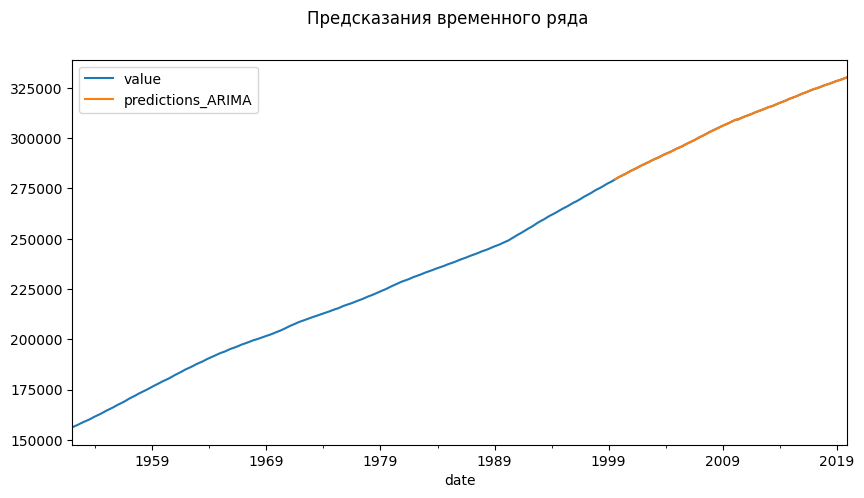

In [26]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Предсказания временного ряда')
data_2.plot(ax=ax, legend=True)
pyplot.show()

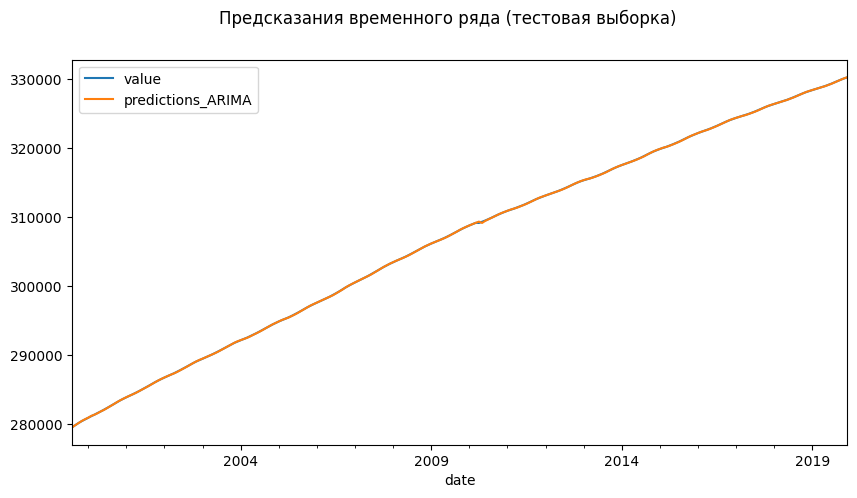

In [27]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Предсказания временного ряда (тестовая выборка)')
data_2[train_size:].plot(ax=ax, legend=True)
pyplot.show()

In [28]:

function_set = ['add', 'sub', 'mul', 'div', 'sin']
SR = SymbolicRegressor(population_size=500, metric='mse',
                               generations=70, stopping_criteria=0.01,
                               init_depth=(4, 10), verbose=1, function_set=function_set,
                               const_range=(-100, 100), random_state=0)

In [29]:
SR.fit(np.array(xnum_train).reshape(-1, 1), train.reshape(-1, 1))

C:\Users\noski\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0   263.65      2.43463e+63       23      7.14077e+09              N/A      2.78m
   1   130.36      5.77055e+16       43      6.06688e+09              N/A     56.60s
   2    53.10      4.58992e+15       34      3.54847e+09              N/A     34.80s
   3    34.28      1.99853e+19       13      1.42699e+09              N/A     27.62s
   4    35.05      2.10424e+16       38      1.04052e+09              N/A     31.71s
   5    30.47      2.56729e+16       36      4.29436e+08              N/A     28.21s
   6    31.30      3.00498e+16       50      6.39791e+07              N/A     25.16s
   7    38.37      8.59782e+15       35      1.51165e+07              N/A     29.67s
   8    43.37      5.29474e+15       47      4.76034e+06              N/A  

SymbolicRegressor(const_range=(-100, 100),
                  function_set=['add', 'sub', 'mul', 'div', 'sin'],
                  generations=70, init_depth=(4, 10), metric='mse',
                  population_size=500, random_state=0, stopping_criteria=0.01,
                  verbose=1)

In [30]:
print(SR._program)

sub(mul(sub(-36.019, -77.644), add(add(add(X0, 51.302), add(add(add(X0, 55.353), mul(55.353, 65.255)), X0)), sub(sub(sub(sub(sub(sub(sub(sub(sub(sub(sub(sub(sub(sub(sub(sub(sub(sub(sub(sub(sub(sub(sub(sub(sub(sub(sub(sub(sub(sub(sub(sub(sub(add(X0, X0), sin(mul(sub(-36.019, -77.644), add(add(add(add(X0, 51.302), add(add(X0, X0), X0)), add(X0, X0)), add(X0, X0))))), sin(mul(sub(sub(sub(add(X0, X0), sin(mul(sub(-36.019, -77.644), add(add(add(add(X0, 51.302), add(add(X0, X0), X0)), add(X0, X0)), add(X0, X0))))), sin(mul(sub(-36.019, -77.644), add(add(add(add(X0, 51.302), add(add(X0, X0), X0)), add(X0, X0)), add(X0, X0))))), sin(mul(sub(-36.019, -77.644), add(add(add(X0, sub(mul(sub(-36.019, -77.644), add(X0, X0)), sub(add(X0, X0), add(add(add(X0, X0), X0), sin(X0))))), 51.302), add(X0, X0))))), add(add(add(add(X0, 51.302), add(add(X0, X0), X0)), sin(mul(sub(-36.019, -77.644), add(add(add(add(X0, 51.302), add(add(X0, X0), X0)), add(X0, X0)), add(X0, X0))))), add(X0, X0))))), sin(mul(sub(-3

In [31]:
# Предсказания
y_sr = SR.predict(np.array(xnum_test).reshape(-1, 1))
y_sr[:10]

array([274891.75793852, 274817.36307349, 275068.42349884, 275594.91553188,
       275909.57465535, 276033.9204471 , 276192.3291504 , 276368.95663777,
       276651.56236873, 276542.01774132])

In [32]:
# Записываем предсказания в DataFrame
data_2['predictions_GPLEARN'] = (train_size * [np.NAN]) + list(y_sr)

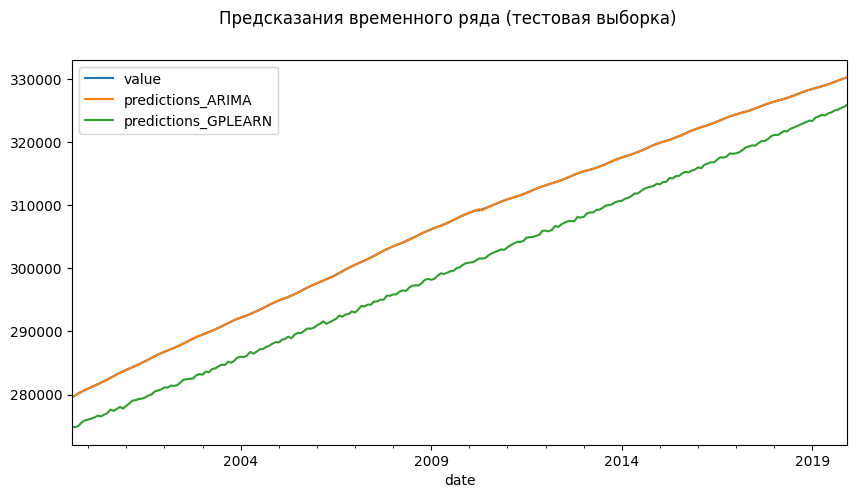

In [33]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Предсказания временного ряда (тестовая выборка)')
data_2[train_size:].plot(ax=ax, legend=True)
pyplot.show()

In [34]:
error_SR = mean_squared_error(test, y_sr, squared=False)


In [35]:
# Ошибка прогноза
np.mean(Y), error_SR

(243847.7678259804, 6510.330169456957)

In [36]:
def print_metrics(y_test, y_pred):
    print(f"R^2: {r2_score(y_test, y_pred)}")
    print(f"MSE: {mean_squared_error(y_test, y_pred, squared=False)}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred)}")

In [37]:
print("ARIMA")
print_metrics(test, predictions_arima)

print("\nGPLEARN")
print_metrics(test, y_sr)

ARIMA
R^2: 0.9999973075905816
MSE: 24.173499561405922
MAE: 16.034435650864996

GPLEARN
R^2: 0.8047153645391025
MSE: 6510.330169456957
MAE: 6443.710113418146
